In [ ]:
%load_ext autoreload
%autoreload 2
import optax, jax
from jax import numpy as jnp
from flax import nnx
from models import ResNet
from fedflax import train
from data import create_imagenet
from matplotlib import pyplot as plt
from collections import defaultdict
n = 4 # number of clients

## Angle and beta

In [ ]:
# Optimizer
opt = lambda model: nnx.Optimizer(
    model,
    optax.adamw(learning_rate=1e-3),
    wrt=nnx.Param
)

# # Sharpness-aware minimization optimizer
# opt = lambda model: nnx.Optimizer(
#     model,
#     optax.contrib.sam(
#         optax.adamw(learning_rate=1e-3),
#         optax.chain(optax.contrib.normalize(), optax.adam(1e-2)),
#         sync_period=5
#     ),
#     wrt=nnx.Param
# )

# Loss includes softmax layer
def return_ell(omega):
    def ell(model, model_g, x_batch, y_batch):
        prox = sum(jax.tree.map(lambda a, b: jnp.sum((a-b)**2), jax.tree.leaves(model), jax.tree.leaves(model_g)))
        ce = optax.softmax_cross_entropy(model(x_batch), y_batch).mean()
        return omega/2*prox + ce, (prox, ce)
    return ell

# Get updates of first communication round for various heterogeneity levels
updateses = []
betas = jnp.log(jnp.linspace(jnp.exp(1),jnp.exp(0.01),30))
for beta in betas:
    ds_train = create_imagenet(feature_beta=beta)
    ds_val = create_imagenet(path="./data/Data/CLS-LOC/val", feature_beta=beta)
    updates = train(ResNet, opt, ds_train, ds_val, return_ell(0.), local_epochs=20, max_patience=None)
    updateses.append(updates)

round 0 global validation accuracy: 0.9609375
round 0 global validation accuracy: 0.951171875
round 0 global validation accuracy: 0.9596354365348816
round 0 global validation accuracy: 0.9459635615348816
round 0 global validation accuracy: 0.9290364980697632
round 0 global validation accuracy: 0.90234375
round 0 global validation accuracy: 0.8717448115348816
round 0 global validation accuracy: 0.8489583730697632
round 0 global validation accuracy: 0.814453125
round 0 global validation accuracy: 0.7845052480697632
round 0 global validation accuracy: 0.7467448115348816
round 0 global validation accuracy: 0.7115885615348816
round 0 global validation accuracy: 0.6953125
round 0 global validation accuracy: 0.625
round 0 global validation accuracy: 0.56640625
round 0 global validation accuracy: 0.525390625
round 0 global validation accuracy: 0.4700520932674408
round 0 global validation accuracy: 0.40234375
round 0 global validation accuracy: 0.396484375
round 0 global validation accuracy: 0.

## Ablation: Vary sample overlap

In [ ]:
# Get updates of first communication round for various heterogeneity levels
updateses = []
overlaps = jnp.log(jnp.linspace(jnp.exp(.5),jnp.exp(1),30))
for overlap in overlaps:
    ds = create_imagenet(beta=1., client_overlap=overlap)
    updates = train(ResNet, opt, x_train, y_train, x_val, y_val, return_ell(0.), local_epochs=20, max_patience=None)
    updateses.append(updates)

round 0 global validation accuracy: 0.9186198115348816
round 0 global validation accuracy: 0.89453125
round 0 global validation accuracy: 0.92578125
round 0 global validation accuracy: 0.9368489980697632
round 0 global validation accuracy: 0.94140625
round 0 global validation accuracy: 0.9466146230697632
round 0 global validation accuracy: 0.951171875
round 0 global validation accuracy: 0.962890625
round 0 global validation accuracy: 0.94140625
round 0 global validation accuracy: 0.9537760615348816
round 0 global validation accuracy: 0.9524739980697632
round 0 global validation accuracy: 0.958984375
round 0 global validation accuracy: 0.9576823115348816
round 0 global validation accuracy: 0.9700521230697632
round 0 global validation accuracy: 0.9563802480697632
round 0 global validation accuracy: 0.96484375
round 0 global validation accuracy: 0.9596354365348816
round 0 global validation accuracy: 0.9661458730697632
round 0 global validation accuracy: 0.9654948115348816
round 0 global v

## Visualizations

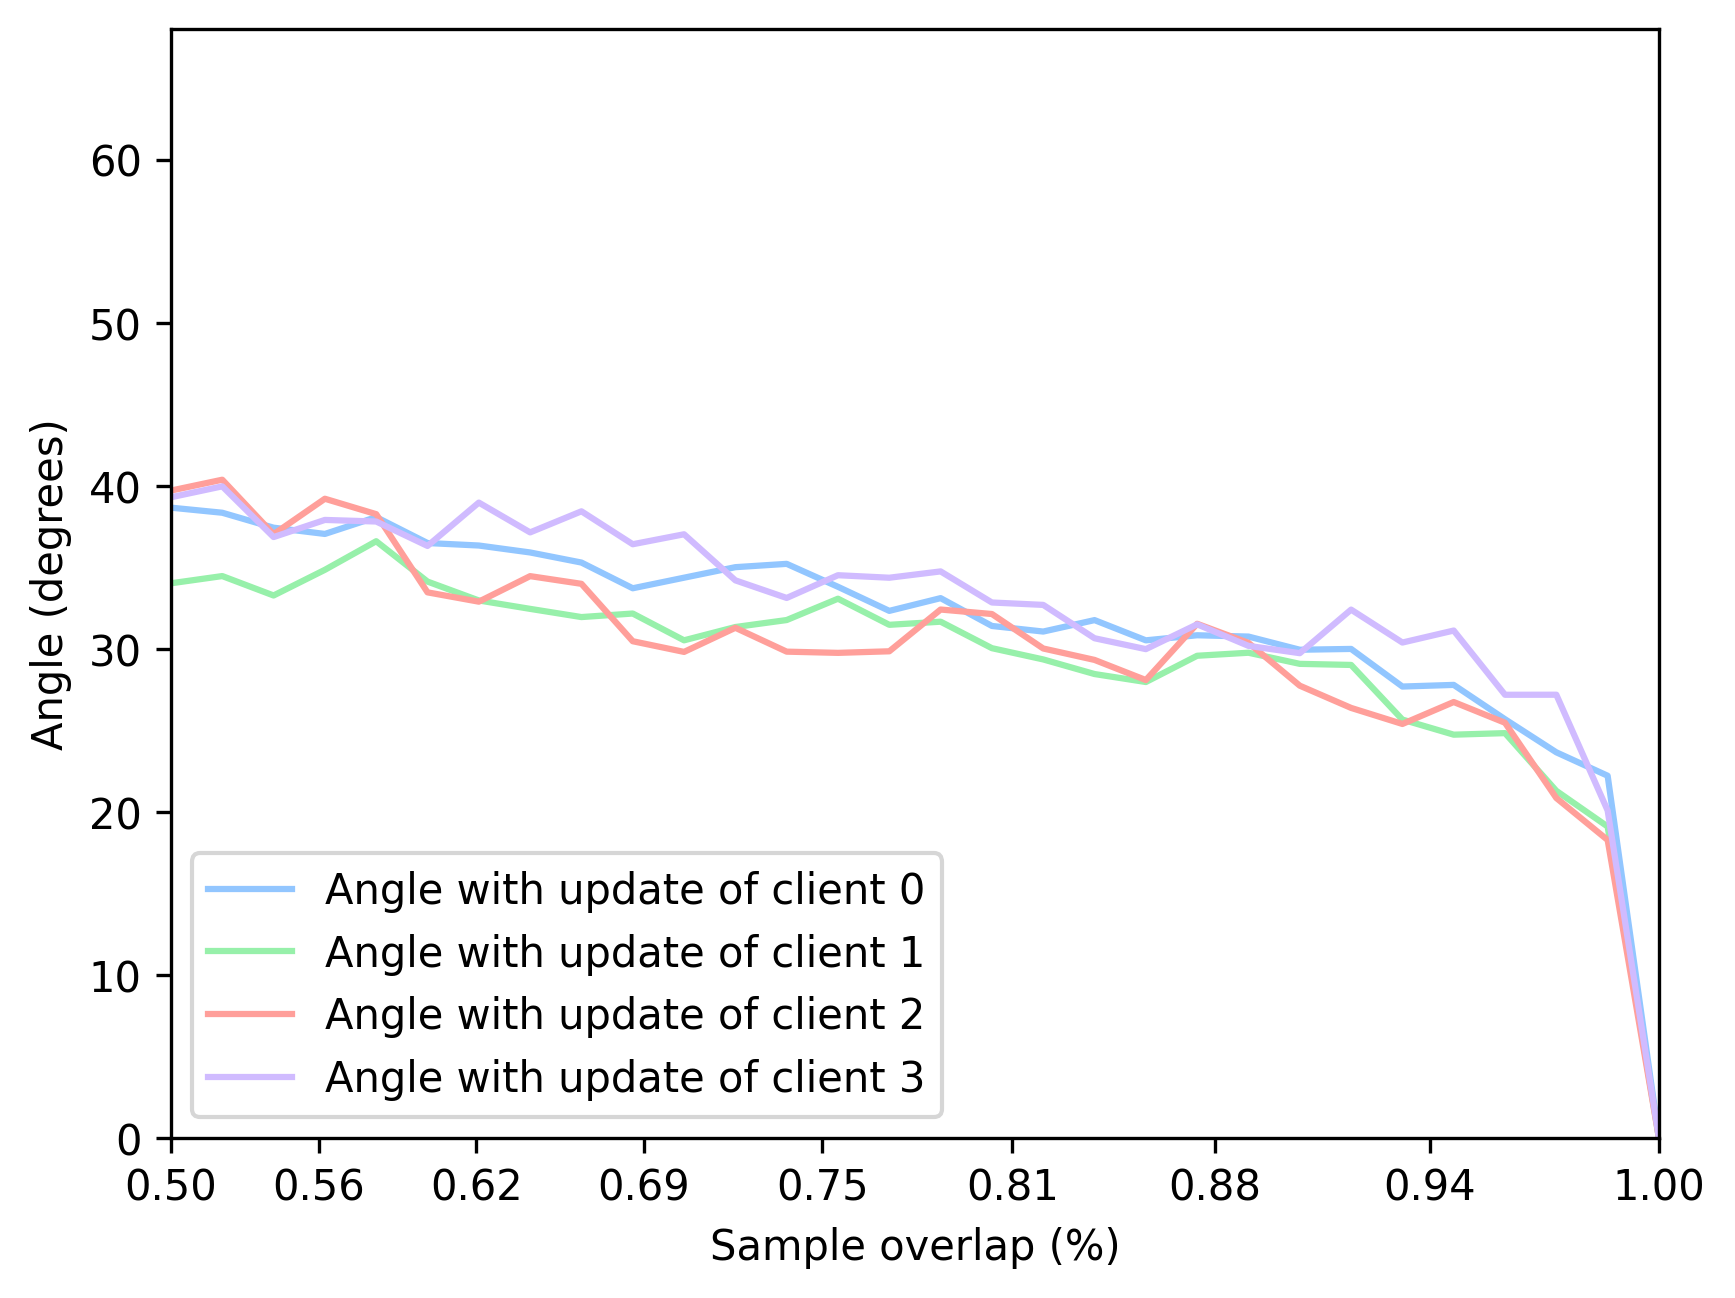

In [ ]:
# Loop over each heterogeneity level 
angles = defaultdict(list)
for i, (beta, updates) in enumerate(zip(overlaps, updateses)): # betas
    # Compute global update as mean of local updates
    update_g = jax.tree.map(lambda updates: jnp.mean(updates, axis=0), updateses[i])
    # Flatten global and local updates
    update_g = jnp.concatenate([jnp.ravel(x) for x in update_g])
    updates = jnp.concatenate(jax.tree.map(lambda x: jnp.reshape(x, (n,-1)), updates), axis=1)
    # Compute angle with global update for each client's update
    for client, update in enumerate(updates):
        angle = jnp.degrees(jnp.arccos(optax.losses.cosine_similarity(update_g, update)))
        angles[client].append(angle.item())

# Plot as function of beta
plt.style.use("seaborn-v0_8-pastel")
fig, ax = plt.subplots(1, dpi=300);
for i in range(len(angles)):
    ax.plot(overlaps, angles[i], label=f"Angle with update of client {i}"); # betas
ax.legend(loc="lower left");
ax.set_xlabel("Sample overlap (%)");#(r"Heterogeneity level ($\beta$)")ck
ax.set_ylabel("Angle (degrees)");
ax.set_ylim(0, 68);
ax.set_xlim(-.005,1.001);
ax.set_xscale("function", functions=(jnp.exp, jnp.log));
ax.set_xticks(jnp.linspace(0.01, 1, 9));
ax.set_xticklabels([f"{x:.2f}" for x in jnp.linspace(0.01, 1, 9)]);

In [97]:
angles_overlap = angles
%store angles_overlap
%store overlaps

Stored 'angles_overlap' (defaultdict)
Stored 'overlaps' (ArrayImpl)
